Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2403 - loss: 1.5869 - val_accuracy: 0.3049 - val_loss: 1.4602 - learning_rate: 0.0010
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2787 - loss: 1.4819 - val_accuracy: 0.3292 - val_loss: 1.4433 - learning_rate: 0.0010
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2841 - loss: 1.4751 - val_accuracy: 0.3358 - val_loss: 1.4312 - learning_rate: 0.0010
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2920 - loss: 1.4628 - val_accuracy: 0.3208 - val_loss: 1.4290 - learning_rate: 0.0010
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2942 - loss: 1.4665 - val_accuracy: 0.3358 - val_loss: 1.4217 - learning_rate: 0.0010
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3051 - loss: 1.4521 - val_accuracy: 0.3376 - val_loss: 1.4152 - learning_rate: 0.0010
Epoch 7/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3145 - loss: 1.4513 - 

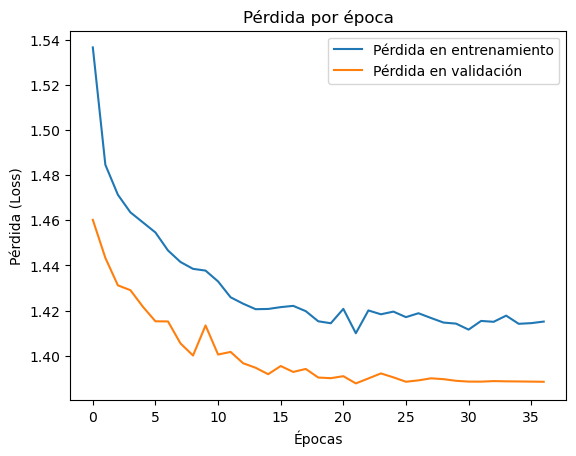

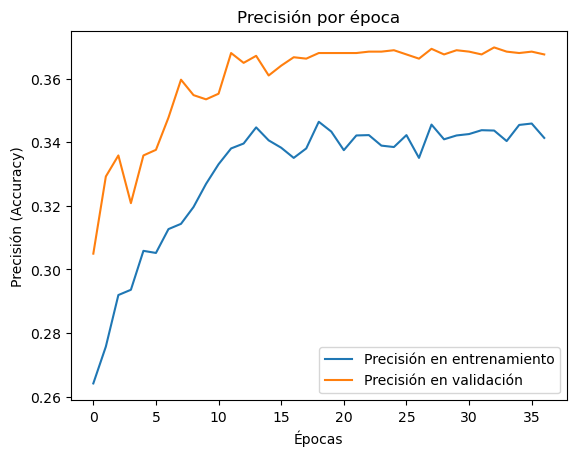

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Cargar el conjunto de datos
data = pd.read_csv('../pet_adoption/data.csv')

# Eliminar las columnas 'Breed2' y 'Color3'
data = data.drop(columns=['Breed2', 'Color3'])

# Separar características y etiqueta objetivo
X = data.drop(columns=['AdoptionSpeed'])
y = data['AdoptionSpeed']

# Variables numéricas
numeric_features = ['Age', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
                    'Sterilized', 'Health', 'Fee', 'PhotoAmt']

# Variables categóricas para embeddings
embedding_features = ['Breed1', 'Color1', 'Color2', 'State']

# Variables categóricas para codificación one-hot
onehot_features = ['Type', 'Gender']

# Eliminar columnas que no aportan al modelo
X = X.drop(columns=['Name', 'PetID'])

# Reemplazar valores NaN por '-'
X = X.fillna('-')

# Dividir el DataFrame en conjuntos de entrenamiento y validación
X_train_df, X_val_df, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar variables numéricas
scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(X_train_df[numeric_features])
X_val_numeric = scaler.transform(X_val_df[numeric_features])

# Embeddings para variables categóricas
embedding_inputs = []
embedding_layers = []
for feature in embedding_features:
    le = LabelEncoder()
    le.fit(X[feature].astype(str))  # Ajustar en todo el conjunto de datos
    X_train_df[feature] = le.transform(X_train_df[feature].astype(str))
    X_val_df[feature] = le.transform(X_val_df[feature].astype(str))
    
    # Definir capas de entrada y embedding
    input_dim = X[feature].nunique() + 1  # Añadir 1 para posibles nuevas categorías
    embed_dim = int(min(np.ceil((input_dim)/2), 50))  # Dimensión del embedding
    inp = Input(shape=(1,), name=f'{feature}_input')
    emb = Embedding(input_dim=input_dim, output_dim=embed_dim, name=f'{feature}_embedding')(inp)
    emb = Flatten()(emb)
    embedding_inputs.append(inp)
    embedding_layers.append(emb)

# Codificación one-hot para algunas variables
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
onehot_encoder.fit(X[onehot_features].astype(str))  # Ajustar en todo el conjunto de datos
X_train_onehot = onehot_encoder.transform(X_train_df[onehot_features].astype(str))
X_val_onehot = onehot_encoder.transform(X_val_df[onehot_features].astype(str))

# Crear capa de entrada para datos one-hot
onehot_input_dim = X_train_onehot.shape[1]
onehot_input = Input(shape=(onehot_input_dim,), name='onehot_input')

# Crear capa de entrada para variables numéricas
numeric_input = Input(shape=(X_train_numeric.shape[1],), name='numeric_input')

# Concatenar todas las entradas
all_inputs = [numeric_input] + embedding_inputs + [onehot_input]
all_embeddings = [numeric_input] + embedding_layers + [onehot_input]

# Concatenar todas las capas de embeddings y entradas
x = Concatenate()(all_embeddings)

# Añadir capas densas
#x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)

# Cambiar la capa de salida a softmax para clasificación
output = Dense(5, activation='softmax', name='output')(x)

# Definir el modelo
model = Model(inputs=all_inputs, outputs=output)

# Compilar el modelo con categorical_crossentropy y accuracy
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Convertir y_train e y_val a categorías (one-hot encoding para la salida)
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=5)

# Preparar los datos de entrada para el modelo
X_train_inputs = [X_train_numeric] + [X_train_df[feature].values for feature in embedding_features] + [X_train_onehot]
X_val_inputs = [X_val_numeric] + [X_val_df[feature].values for feature in embedding_features] + [X_val_onehot]

# Callback para Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Callback para ajustar el learning rate si el val_loss no mejora
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Entrenar el modelo
history = model.fit(
    x=X_train_inputs,
    y=y_train_cat,
    validation_data=(X_val_inputs, y_val_cat),
    epochs=50,
    batch_size=80,
    callbacks=[early_stopping, reduce_lr]  # Añadir EarlyStopping y ReduceLROnPlateau como callbacks
)

# Graficar la pérdida (loss) por época
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida por época')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.legend()
plt.show()

# Graficar la precisión (accuracy) por época
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión por época')
plt.xlabel('Épocas')
plt.ylabel('Precisión (Accuracy)')
plt.legend()
plt.show()
